> Ref: Amplitude의 [Product Analytics Playbook: Mastering Retention](https://www.productanalyticsplaybook.com/#top)

위의 내용 中 1. **리텐션 커브** 2. **리텐션 라이프사이클 프레임워크** 에 대한 분석 및 시각화 작업과 이를 파이프라인화 할 수 있는 메소드를 만들어본다.

# 1. 데이터 가공 단계

- 소스가 되는 데이터의 형태는 웹/앱에서 발생하는 이벤트 로그를 가정
- 이벤트 로그를 기반으로 리텐션 분석이 가능한 형태의 테이블 만들기
- 데이터 처리는 pyspark를 통해 진행

In [1]:
import os
# os.environ["PYSPARK_PYTHON"] = "/opt/homebrew/bin/python3"

In [2]:
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark import SparkContext

In [3]:
MAX_MEMORY = "32g"
SPARK = (
    SparkSession.builder.appName("Plots Tutorial Shell")
    .config("spark.driver.host", "localhost")
    .config("spark.driver.memory", MAX_MEMORY)
    .config("spark.sql.session.timeZone", "Asia/Seoul")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .getOrCreate()
)

21/07/12 15:49:54 WARN Utils: Your hostname, DESKTOP-D0UBG2L resolves to a loopback address: 127.0.1.1; using 172.21.193.13 instead (on interface eth0)
21/07/12 15:49:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/07/12 15:49:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
from abc import ABC, abstractmethod

from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, StructField, StructType, TimestampType


class DataMart(ABC):
    schema: StructType

    def __init__(self, spark: SparkSession):
        self.spark = spark

    @abstractmethod
    def df(self, **kwargs) -> DataFrame:
        raise NotImplementedError()

    def fix_schema(self, df: DataFrame) -> DataFrame:
        select_expr_list = []
        for field in self.schema:
            select_expr_list.append(col(field.name).cast(field.dataType))

        return df.select(*select_expr_list)


class EventMart(DataMart):
    event_name: str

    schema = StructType(
        [
            StructField("timestamp", TimestampType()),
            StructField("user_id", StringType()),
            StructField("event_name", StringType()),
        ]
    )

In [5]:
import datetime

In [6]:
# event log samples
class SampleEventMart(EventMart):
    event_name = "chat"

    def df(self):
        df = self.spark.createDataFrame(
            [
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="800", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="600", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="580", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="582", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="550", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="800", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="600", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="580", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 5, 1, 1, 1), user_id="582", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 6, 1, 1, 1), user_id="550", event_name="chat"),
            ]
        )

        return self.fix_schema(df=df)

sample_event_mart = SampleEventMart(spark=SPARK)

## TASK1: 특정 이벤트 발생을 기준으로 유저 리텐션 측정

In [7]:
import datetime
from collections import defaultdict
from math import floor
from typing import Dict, Iterable, List, Literal, Optional, Union

from pyspark.sql import DataFrame, Row, SparkSession
from pyspark.sql import Window as W
from pyspark.sql import functions as F
from pyspark.sql import types as T

Retention 측정 방법 세 가지
1. N-Day
2. Bracket
3. Unbounded

In [8]:
RetentionType = Union[Literal["N-Day"], Literal["Bracket"], Literal["Unbounded"]]

In [9]:
class RetentionMart(DataMart):
    schema = T.StructType(
        [
            T.StructField("event_name", T.StringType()),
            T.StructField("retention_type", T.StringType()),
            T.StructField("period_index", T.IntegerType()),
            T.StructField(
                "date_period",
                T.StructType(
                    [
                        T.StructField("from", T.DateType()),
                        T.StructField("to", T.DateType()),
                    ]
                ),
            ),
            T.StructField("num_users", T.IntegerType()),
            T.StructField("retention_rate", T.FloatType()),
        ]
    )

    template_schema = T.StructType(
        [
            T.StructField("retention_type", T.StringType()),
            T.StructField("period_index", T.IntegerType()),
            T.StructField(
                "date_period",
                T.StructType(
                    [
                        T.StructField("from", T.DateType()),
                        T.StructField("to", T.DateType()),
                    ]
                ),
            ),
        ]
    )

    def __init__(self, spark: SparkSession, type: RetentionType):
        self.spark = spark
        self.type = type

    def nday(
        self,
        event_df: DataFrame,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        window_size = (end_date - start_date).days + 1
        template = self.spark.createDataFrame(
            [
                Row(
                    retention_type=self.type,
                    period_index=i,
                    date_period={
                        "from": start_date + datetime.timedelta(days=i),
                        "to": start_date + datetime.timedelta(days=i),
                    },
                )
                for i in range(window_size)
            ],
            schema=self.template_schema,
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in df_with_date.filter(F.col("date") == start_date)
                .select("user_id")
                .collect()
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        df_grouped = (
            df_filtered.groupBy("event_name", "date")
            .agg(F.size(F.collect_set("user_id")).alias("num_users"))
            .withColumn(
                "period_index",
                F.row_number().over(W.orderBy("date")) - 1,
            )
        )

        retention_df = (
            template.join(
                df_grouped.select(
                    "event_name",
                    "period_index",
                    "num_users",
                ),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def get_date_brackets(
        self,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_sizes: List[int],
    ) -> List[Dict[str, datetime.date]]:
        idx = 0
        lower = start_date
        upper = min(
            [start_date + datetime.timedelta(days=bracket_sizes[idx] - 1), end_date]
        )
        brackets = [{"from": lower, "to": upper}]
        while idx + 1 < len(bracket_sizes) and upper < end_date:
            idx += 1
            lower = upper + datetime.timedelta(days=1)
            upper = min([upper + datetime.timedelta(days=bracket_sizes[idx]), end_date])
            brackets.append({"from": lower, "to": upper})

        return brackets

    def bracket(
        self,
        event_df: DataFrame,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_size: Optional[int],
        custom_bracket_sizes: Optional[List[int]],
    ) -> DataFrame:
        if custom_bracket_sizes:
            _brackets = self.get_date_brackets(
                start_date=start_date,
                end_date=end_date,
                bracket_sizes=custom_bracket_sizes,
            )
        elif bracket_size:
            window_size = (end_date - start_date).days + 1
            bracket_sizes = [bracket_size] * floor(window_size / bracket_size)
            bracket_sizes += [window_size - sum(bracket_sizes)]
            _brackets = self.get_date_brackets(
                start_date=start_date,
                end_date=end_date,
                bracket_sizes=bracket_sizes,
            )
        else:
            raise TypeError("bracket_size or custom_brack_sizes needed")

        template = self.spark.createDataFrame(
            [
                Row(retention_type=self.type, period_index=idx, date_period=bracket)
                for idx, bracket in enumerate(_brackets)
            ],
            schema=self.template_schema,
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in (
                    df_with_date.filter(
                        (F.col("date") >= _brackets[0]["from"])
                        & (F.col("date") <= _brackets[0]["to"])
                    )
                    .select("user_id")
                    .collect()
                )
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        @F.udf(T.IntegerType())
        def bracket_mapper(date: datetime.date):
            for idx, bracket in enumerate(_brackets):
                if date >= bracket["from"] and date <= bracket["to"]:
                    return idx

        df_grouped = (
            df_filtered.withColumn("period_index", bracket_mapper(F.col("date")))
            .groupBy("event_name", "period_index")
            .agg(F.size(F.collect_set("user_id")).alias("num_users"))
        )

        retention_df = (
            template.join(
                df_grouped.select(
                    "event_name",
                    "period_index",
                    "num_users",
                ),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def unbounded(
        self,
        event_df: DataFrame,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        window_size = (end_date - start_date).days + 1
        template = self.spark.createDataFrame(
            [
                Row(
                    retention_type=self.type,
                    period_index=i,
                    date_period={
                        "from": start_date + datetime.timedelta(days=i),
                        "to": start_date + datetime.timedelta(days=i),
                    },
                )
                for i in range(window_size)
            ],
            schema=self.template_schema,
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in df_with_date.filter(F.col("date") == start_date)
                .select("user_id")
                .collect()
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        df_grouped = (
            df_filtered.withColumn(
                "num_users",
                F.size(
                    F.collect_set("user_id").over(
                        W.partitionBy()
                        .orderBy("date")
                        .rowsBetween(W.currentRow, W.unboundedFollowing)
                    )
                ),
            )
            .dropDuplicates(["date"])
            .withColumn(
                "period_index",
                F.row_number().over(W.orderBy("date")) - 1,
            )
        )

        retention_df = (
            template.join(
                df_grouped.select(
                    "event_name",
                    "period_index",
                    "num_users",
                ),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def df(
        self,
        event_mart: EventMart,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_size: Optional[int] = None,
        custom_bracket_sizes: Optional[List[int]] = None,
    ) -> DataFrame:
        if self.type == "N-Day":
            retention_df = self.nday(
                event_df=event_mart.df(),
                start_date=start_date,
                end_date=end_date,
            )
        elif self.type == "Bracket":
            retention_df = self.bracket(
                event_df=event_mart.df(),
                start_date=start_date,
                end_date=end_date,
                bracket_size=bracket_size,
                custom_bracket_sizes=custom_bracket_sizes,
            )
        elif self.type == "Unbounded":
            retention_df = self.unbounded(
                event_df=event_mart.df(),
                start_date=start_date,
                end_date=end_date,
            )
        else:
            raise TypeError("Retention type undefined")

        return self.fix_schema(df=retention_df)

### N-day 방식 샘플

In [10]:
retention_mart = RetentionMart(spark=SPARK, type="N-Day")

In [11]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6)
)

In [12]:
retention_df.show(20, False)

21/07/12 15:50:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |N-Day         |0           |[2021-07-01, 2021-07-01]|8        |1.0           |
|chat      |N-Day         |1           |[2021-07-02, 2021-07-02]|3        |0.375         |
|chat      |N-Day         |2           |[2021-07-03, 2021-07-03]|4        |0.5           |
|chat      |N-Day         |3           |[2021-07-04, 2021-07-04]|2        |0.25          |
|chat      |N-Day         |4           |[2021-07-05, 2021-07-05]|1        |0.125         |
|chat      |N-Day         |5           |[2021-07-06, 2021-07-06]|1        |0.125         |
+----------+--------------+------------+------------------------+---------+--------------+



### Bracket 방식 샘플

In [13]:
retention_mart = RetentionMart(spark=SPARK, type="Bracket")

In [14]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6),
    bracket_size=2
)

In [15]:
retention_df.show(20, False)

+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |Bracket       |0           |[2021-07-01, 2021-07-02]|8        |1.0           |
|chat      |Bracket       |1           |[2021-07-03, 2021-07-04]|6        |0.75          |
|chat      |Bracket       |2           |[2021-07-05, 2021-07-06]|2        |0.25          |
+----------+--------------+------------+------------------------+---------+--------------+



### Unbounded 방식 샘플

In [16]:
retention_mart = RetentionMart(spark=SPARK, type="Unbounded")

In [17]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6),
)

In [18]:
retention_df.show(20, False)

21/07/12 15:50:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/12 15:50:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |Unbounded     |0           |[2021-07-01, 2021-07-01]|8        |1.0           |
|chat      |Unbounded     |1           |[2021-07-02, 2021-07-02]|8        |1.0           |
|chat      |Unbounded     |2           |[2021-07-03, 2021-07-03]|8        |1.0           |
|chat      |Unbounded     |3           |[2021-07-04, 2021-07-04]|4        |0.5           |
|chat      |Unbounded     |4           |[2021-07-05, 2021-07-05]|2        |0.25          |
|chat      |Unbounded     |5           |[2021-07-06, 2021-07-06]|1        |0.125         |
+----------+--------------+------------+------------------------+---------+--------------+



## TASK2: 리텐션 라이프사이클에 따른 유저 그룹 분류

1. New Users
2. Current Users(+Power Users)
3. Resurrected Users
4. Dormant Users

유저 그룹 분류를 위해서는 이벤트 유형에 따른 유저의 리텐션 주기를 미리 파악하고 있어야 함

*chat 이벤트의 주기는 하루(daily)로 가정*

In [19]:
class UserGroupMart(DataMart):
    schema = T.StructType(
        [
            T.StructField("event_name", T.StringType()),
            T.StructField("date", T.DateType()),
            T.StructField("new_users", T.IntegerType()),
            T.StructField("current_users", T.IntegerType()),
            T.StructField("resurrected_users", T.IntegerType()),
            T.StructField("dormant_users", T.IntegerType()),
        ]
    )

    def get_intervals(
        self,
        today: datetime.date,
        retention_cycle: int,
    ) -> Iterable[List[datetime.date]]:
        current_interval = []
        for i in range(retention_cycle):
            current_interval.append(today - datetime.timedelta(days=i))
        current_interval.sort()

        previous_interval = []
        for j in range(retention_cycle, retention_cycle * 2):
            previous_interval.append(today - datetime.timedelta(days=j))
        previous_interval.sort()

        return previous_interval, current_interval

    def df(
        self,
        event_mart: EventMart,
        cycle_days: int,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        df_filtered = (
            event_mart.df()
            .withColumn("date", F.col("timestamp").cast(T.DateType()))
            .filter((F.col("date") >= start_date) & (F.col("date") <= end_date))
        )

        df_grouped = (
            df_filtered.withColumn(
                "new_user_flag",
                F.when(
                    F.min("timestamp").over(W.partitionBy("user_id"))
                    == F.col("timestamp"),
                    F.col("user_id"),
                ).otherwise(F.lit(None)),
            )
            .withColumn(
                "all_users_so_far",
                F.collect_set("user_id").over(
                    W.partitionBy()
                    .orderBy("timestamp")
                    .rowsBetween(W.unboundedPreceding, W.currentRow)
                ),
            )
            .orderBy("timestamp")
            .groupBy("event_name", "date")
            .agg(
                F.collect_set("user_id").alias("active_users"),
                F.collect_set("new_user_flag").alias("new_users"),
                F.last("all_users_so_far").alias("user_pool"),
            )
        )

        daily_user_groups = {
            row.date: {
                "active_users": row.active_users,
                "new_users": row.new_users,
                "user_pool": row.user_pool,
            }
            for row in df_grouped.collect()
        }

        date_range = [
            start_date + datetime.timedelta(days=i)
            for i in range((end_date - start_date).days + 1)
        ]
        user_segmentations = defaultdict(dict)
        for date in date_range:
            previous_interval, current_interval = self.get_intervals(
                today=date, retention_cycle=cycle_days
            )

            # 1. New Users & Active Users
            new_users = set()
            active_users = set()
            for _date in set(current_interval) & set(date_range):
                new_users |= set(daily_user_groups[_date]["new_users"])
                active_users |= set(daily_user_groups[_date]["active_users"])

            user_segmentations[date]["new_users"] = new_users

            # 2. Current Users
            was_active_users = set()
            for _date in set(previous_interval) & set(date_range):
                if _date not in date_range:
                    continue
                was_active_users |= set(daily_user_groups[_date]["active_users"])

            user_segmentations[date]["current_users"] = active_users & was_active_users

            # 3. Resurrected Users
            user_segmentations[date]["resurrected_users"] = (
                active_users - was_active_users - new_users
            )

            # 4. Dormant Users
            user_pool_so_far = set(daily_user_groups[date]["user_pool"])

            user_segmentations[date]["dormant_users"] = user_pool_so_far - active_users

        user_group_df = self.spark.createDataFrame(
            [
                Row(
                    event_name=event_mart.event_name,
                    date=date,
                    new_users=len(user_groups["new_users"]),
                    current_users=len(user_groups["current_users"]),
                    resurrected_users=len(user_groups["resurrected_users"]),
                    dormant_users=len(user_groups["dormant_users"]),
                )
                for date, user_groups in user_segmentations.items()
            ]
        )

        return self.fix_schema(df=user_group_df)

### 유저 그룹 분류 샘플

In [20]:
user_group_mart = UserGroupMart(spark=SPARK)

In [21]:
user_group_df = user_group_mart.df(
    event_mart=sample_event_mart,
    cycle_days=1,
    start_date=datetime.date(2021, 7, 1),
    end_date=datetime.date(2021, 7, 6)
)

21/07/12 15:50:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [22]:
user_group_df.show()

+----------+----------+---------+-------------+-----------------+-------------+
|event_name|      date|new_users|current_users|resurrected_users|dormant_users|
+----------+----------+---------+-------------+-----------------+-------------+
|      chat|2021-07-01|        8|            0|                0|            0|
|      chat|2021-07-02|        0|            3|                0|            5|
|      chat|2021-07-03|        0|            2|                2|            4|
|      chat|2021-07-04|        0|            0|                2|            6|
|      chat|2021-07-05|        0|            0|                1|            7|
|      chat|2021-07-06|        0|            0|                1|            7|
+----------+----------+---------+-------------+-----------------+-------------+



# 2. 시각화 단계

- seaborn 사용해서 기본 테마 잡고
- color 직접 지정해서 plot 커스텀할 수 있는 시각화 메소드 구현

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## TASK1: 리텐션 커브 &rarr; Line Plot

In [24]:
from typing import Tuple

In [25]:
def plot_retention_curve(
    retention_df: DataFrame,
    figsize: Tuple[str],
    facecolor: str,
    linecolor: str,
    linestyle: str,
    marker: str,
    markersize: int,
    fontfamily: str,
    fontcolor: str,
    fontsize: int
) -> plt.Figure:
    
    data = retention_df.orderBy("period_index").select("period_index", "date_period", "retention_rate", "num_users").collect()
    x_period = [row.period_index for row in data]
    xlabel_dateperiod = [row.date_period for row in data]
    y_retention_rate = [row.retention_rate for row in data]
    y_num_users = [row.num_users for row in data]
    
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        font=fontfamily,
        rc={
            "figure.figsize": figsize,
            "axes.facecolor": facecolor,
        }
    )
    fig = plt.figure()
    ax = fig.subplots()
    
    ax.plot(
        x_period,
        y_retention_rate,
        color=linecolor,
        ls=linestyle,
        marker=marker,
        ms=markersize,
    )

    # Set plot title
    ax.set_title("Retention Curve", size=fontsize*1.5, color=fontcolor)

    # Set x tick & label
    ax.set_xlabel(None)
    ax.set_xticks(x_period)
    retention_type = retention_df.select("retention_type").first().retention_type
    if retention_type == "Bracket":
        x_labels = [
            f"{date_period['from'].month}/{date_period['from'].day}~{date_period['to'].month}/{date_period['to'].day}" 
            for date_period in xlabel_dateperiod
        ]
        ax.set_xticklabels(x_labels, fontsize=fontsize, color=fontcolor, rotation=20)
    else:
        x_labels = [f"{date_period['from'].month}/{date_period['from'].day}" for date_period in xlabel_dateperiod]
        ax.set_xticklabels(x_labels, fontsize=fontsize, color=fontcolor)

    # Set y tick & label
    ax.set_ylabel(None)
    ax.set_yticks(np.arange(0, 1.01, .1))
    ax.set_yticks(np.arange(0, 1.01, .05), minor=True)
    y_labels = ["{:.0%}".format(r) for r in np.arange(0, 1.01, .1)]
    ax.set_yticklabels(y_labels, fontsize=fontsize, color=fontcolor)

    # Set grid
    ax.grid(True, which="major", axis="y", ls=":")
    ax.grid(True, axis="x", ls=":")

    # Annotate
    for x, y, num_users in zip(x_period, y_retention_rate, y_num_users):
        ax.text(
            x - 0.1, y + 0.02, f"{int(num_users)} Users", 
            size=fontsize, 
            color=fontcolor
        )
    
    return fig

In [26]:
figsize = (10, 8)
facecolor = "#e6ecff"
linecolor = "#3269ff"
linestyle = ":"
marker = "s"
markersize = 10
fontfamily = "sans-serif"
fontcolor = "#003de6"
fontsize = 12

21/07/12 15:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/12 15:50:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/12 15:50:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


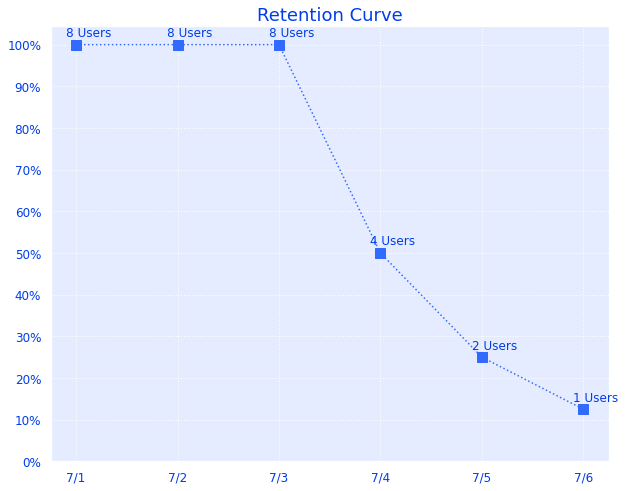

In [27]:
fig = plot_retention_curve(
    retention_df=retention_df,
    figsize=figsize,
    facecolor=facecolor,
    linecolor=linecolor,
    linestyle=linestyle,
    marker=marker,
    markersize=markersize,
    fontfamily=fontfamily,
    fontcolor=fontcolor,
    fontsize=fontsize
)

In [28]:
# fig.savefig("../images/test_retention_curve.png")

## TASK2: 시간에 따른 Activer Users 변화 &rarr; Bar Plot

## TASK3: 리텐션 라이프사이클에 따른 User Group 분포 &rarr; Nested Pie Chart